In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


D:\anomaly-detection


In [2]:
import os.path
import sys
sys.path.insert(0, '/home/rosneft_user_2500/anomaly-detection')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf
from src.features.build_features import rolling_window
from src.models.DDRE import *
from src.visualization.visualize import ratios_plot
cf.go_offline(connected=True)

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# Artificial dataset

In [4]:
search_params = dict(
    sigma_candidates=np.array([0.1, 1, 5, 10, 20, 50, 100, 1000], dtype=np.float32),
    chunk_size=50,
    R=3,
)

params = dict(
    n_rf_te=32,
    verbose=False,
    # build args
    eps=0.001, min_delta=0.01, iterations=100,
    # update args
    learning_rate=1, reg_parameter=0.01,
    chunks=1
)

## Example 1

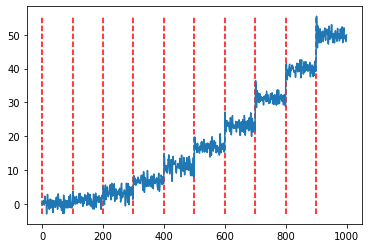

In [5]:
# Lets check algorithm on synthetic dataset
n = 1000
mean = 0
step = 100
y = np.zeros(n, dtype=float)
for i in range(2, n):
    if i % step == 0:
        mean = mean + i // step
    y[i] = y[i-1]*0.6 - y[i-2]*0.5 + mean + np.random.randn()

plt.plot(y)
plt.vlines(list(range(0, n, step)), np.min(y), np.max(y), linestyle='--', colors='r')

In [9]:
pd.DataFrame(data=dict(first_component=y)).to_csv('data/processed/example.csv', index_label='Index')

In [6]:
search_params['width_candidates'] = [50, 60, 70, 80]
ratios, _, peaks = compute_ratios_hp(y.reshape(-1, 1), search_params, params)

Finding hyperparams...
Candidate 50


/home/rosneft_user_2500/anomaly-detection/src/models/DDRE.py:171: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))

/home/rosneft_user_2500/anomaly-detection/src/models/DDRE.py:171: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))



Optimal sigma is: 10.0


/home/rosneft_user_2500/anomaly-detection/src/models/DDRE.py:245: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))



Computing ratios in parrallel with 1 chunks
Candidate 60
Optimal sigma is: 10.0
Computing ratios in parrallel with 1 chunks
Candidate 70
Optimal sigma is: 5.0
Computing ratios in parrallel with 1 chunks
Candidate 80
Optimal sigma is: 5.0
Computing ratios in parrallel with 1 chunks

Optimal width is 80

Starting compute ratios...
Computing ratios in parrallel with 1 chunks


In [7]:
ratios_plot(ratios, peaks)

In [ ]:
# print(f'In given to the model dataset, point from ratios graphic correspond \
# to point in [x-{params["n_rf_te"]}, x+{
# }]')

## Example 2

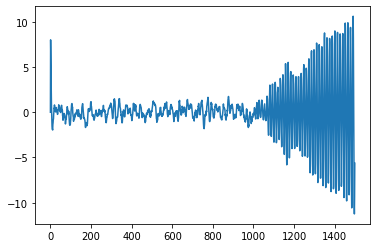

In [8]:
y = [0, 8, 6, 4]

for i in range(4, 1000):
    y.append(0.97 * y[i-1] + 0.4 * y[i - 2] - 0.5 * y[i-3] + 0.2 * np.random.randn())
for i in range(1000, 1500):
    y.append(0.97 * y[i-1] + 0.4 * y[i - 2] - 0.8 * y[i-3] + 0.2 * np.random.randn())

true_change_points = [1000]
y = np.array(y).reshape(-1,1)

plt.plot(y)

In [9]:
search_params['width_candidates'] = [300, 400, 500]
ratios, _, peaks = compute_ratios_hp(y, search_params, params)

Finding hyperparams...
Candidate 300
Optimal sigma is: 1.0
Computing ratios in parrallel with 1 chunks
Candidate 400
Optimal sigma is: 1.0
Computing ratios in parrallel with 1 chunks
Candidate 500
Optimal sigma is: 5.0
Computing ratios in parrallel with 1 chunks

Optimal width is 500

Starting compute ratios...
Computing ratios in parrallel with 1 chunks


In [10]:
ratios_plot(ratios, peaks)

## Example 3. Blending

In [12]:
x = np.linspace(0, 2, num=200)
y1 = np.sin(2 * np.pi * x)
y2 = np.sin(4 * np.pi * x)
y3 = np.sinh((x - 1) * 2)
y4 = np.cosh((x - 1) * 2)
y5 = np.exp((x - 1) * 2)

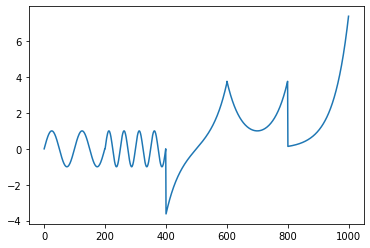

In [13]:
y = np.hstack((y1, y2, y3, y4, y5)).reshape(-1, 1)
plt.plot(y)

In [15]:
search_params['width_candidates'] = [100, 150, 200]
ratios, _, peaks = compute_ratios_hp(y.reshape(-1, 1), search_params, params)

Finding hyperparams...
Candidate 100
Optimal sigma is: 1000.0
Computing ratios in parrallel with 1 chunks
Candidate 150
Optimal sigma is: 1000.0
Computing ratios in parrallel with 1 chunks
Candidate 200
Optimal sigma is: 5.0
Computing ratios in parrallel with 1 chunks

Optimal width is 200

Starting compute ratios...
Computing ratios in parrallel with 1 chunks


In [16]:
ratios_plot(ratios, peaks)

# Real data

In [4]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [5]:
search_params = dict(
    width_candidates=[100], # already founded
    sigma_candidates=np.array([200], dtype=np.float32), # already founded
    chunk_size=350,
    R=3
)

params = dict(
    n_rf_te=50,
    verbose=True,
    chunks=6,
    # build args
    eps=0.001, min_delta=0.01, iterations=100,
    # update args
    learning_rate=1, reg_parameter=0.01,
)

## Вставка change-point

### Все компоненты

In [ ]:
from src.data.generate import insert_anomalies

anomalies_kwargs = dict(
    amount=30,
    axis=0,
    anomaly_length=50
)

In [ ]:
changed_df, anom_start_idxs = insert_anomalies(data, **anomalies_kwargs)

In [ ]:
ratios, _, peaks = compute_ratios_hp(changed_df, search_params, params)

In [ ]:
ratios_plot(ratios, peaks, anom_start_idxs, anomalies_kwargs['anomaly_length'], params['window_width'])

In [ ]:
width, height = 8, 4
ncols = 2
nrows = 21

plt.figure(figsize=(width * ncols, height * nrows))
for i in range(changed_df.shape[1]):
    plt.subplot(nrows, ncols, i+1)
    plt.title(f'Component {i+1}')
    plt.plot(changed_df[:, i])

for start_idx in anom_start_idxs:
    i, j = start_idx
    plt.subplot(nrows, ncols, j+1)
    right = i+anomalies_kwargs['anomaly_length']
    plt.plot(np.arange(i,right),changed_df[i:right, j], c='r')

### Одна компонента

In [ ]:
component = 7

rat = data[str(component)]

In [ ]:
from src.data.generate import insert_anomalies

anomalies_kwargs = dict(
    amount=10,
    axis=0,
    anomaly_length=50
)

changed_rat, anom_start_idxs = insert_anomalies(rat.to_numpy().reshape(-1, 1), **anomalies_kwargs)

In [ ]:
ratios, _, peaks = compute_ratios_hp(changed_rat, search_params, params)

In [ ]:
ratios_plot(ratios, peaks, anom_start_idxs, anomalies_kwargs['anomaly_length'], params['window_width'])

In [ ]:
width, height = 14, 8

plt.figure(figsize=(width, height))

plt.plot(changed_rat)
for start_idx in anom_start_idxs:
    i, j = start_idx
    right = i+anomalies_kwargs['anomaly_length']
    plt.plot(np.arange(i,right),changed_rat[i:right, j], c='r')

## Без вставки change-point'ов

In [6]:
ratios, _, peaks = compute_ratios_hp(data.to_numpy(), search_params, params)

Finding hyperparams...


D:\anomaly-detection\src\models\DDRE.py:171: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))

D:\anomaly-detection\src\models\DDRE.py:171: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))




Optimal width is 100

Starting compute ratios...


D:\anomaly-detection\src\models\DDRE.py:244: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))



Computing ratios in parrallel with 6 chunks
0 15 %
5 15 %
3 15 %
2 15 %
1 15 %
4 15 %
0 20 %
5 20 %
2 20 %
1 20 %
4 20 %
3 20 %
5 25 %
0 25 %
2 25 %
4 25 %
1 25 %
3 25 %
5 30 %
2 30 %
0 30 %
4 30 %
1 30 %
3 30 %
5 35 %
2 35 %
0 35 %
4 35 %
1 35 %
3 35 %
2 40 %
5 40 %
0 40 %
1 40 %
4 40 %
3 40 %
5 45 %
2 45 %
0 45 %
4 45 %
1 45 %
3 45 %
5 50 %
2 50 %
0 50 %
4 50 %
1 50 %
3 50 %
2 55 %
5 55 %
0 55 %
4 55 %
1 55 %
3 55 %
2 60 %
5 60 %
0 60 %
4 60 %
1 60 %
3 60 %
2 65 %
5 65 %
0 65 %
4 65 %
1 65 %
3 65 %
5 70 %
2 70 %
0 70 %
4 70 %
1 70 %
3 70 %
2 75 %
5 75 %
0 75 %
4 75 %
1 75 %
3 75 %
2 80 %
5 80 %
0 80 %
4 80 %
1 80 %
3 80 %
2 85 %
5 85 %
0 85 %
4 85 %
1 85 %
3 85 %
2 90 %
5 90 %
0 90 %
4 90 %
1 90 %
3 90 %
2 95 %
5 95 %
0 95 %
4 95 %
1 95 %
3 95 %


In [7]:
# Было
ratios_plot(ratios, peaks)

In [8]:
np.save('result/TEP_small-ratios.npy', ratios)
np.save('result/TEP_small-peaks.npy', peaks)